In [13]:
import json
from pprint import pprint
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch

from src.reinforcement.goal_directed_model_based_rl.model import SimpleStochasticActorCritic,\
    SimpleStochasticModelDynamics, SimpleDeterministicPolicy, SimpleDeterministicModelDynamics, EnsembleDeterministicModelDynamicsDeltaPredict
from src.reinforcement.goal_directed_model_based_rl.env import VTLEnvWithReferenceTransitionMaskedEntropyScore
from src.reinforcement.goal_directed_model_based_rl.algs.model_based_multi_step_backprop_with_ensemble_classifier import ModelBasedMultiStepBackPropWithEnsembleClassifier
from src.speech_classification.pytorch_conv_lstm import LstmNet, LstmNetEnsemble


In [14]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [22]:
model_dir = r'C:\Study\SpeechAcquisitionModel\reports\videos\video_ensemble_multi_step_05_17_2019_03_44_PM'

In [23]:
with open('train_multi_stepbackprop_mfcc_config_with_ensemble_classifier.json') as data_file:
    kwargs = json.load(data_file)

In [26]:
model_dynamics = torch.load(model_dir + '/model_dynamics.pickle')
agent = torch.load(model_dir + '/agent.pickle')


In [18]:
device = 'cpu'
kwargs['mbbackprop']['device'] = device

speaker_fname = os.path.join(kwargs['env']['vtl_dir'], 'JD2.speaker')
lib_path = os.path.join(kwargs['env']['vtl_dir'], 'VocalTractLab2.dll')

env = VTLEnvWithReferenceTransitionMaskedEntropyScore(lib_path, speaker_fname, **kwargs['env'])
env.reset(train_mode=True)

Compile date of the library: "Mar  6 2019"


array([ 2.66517292e-01, -4.23394096e+00,  0.00000000e+00, -4.39989107e+00,
        8.91013641e-02,  1.07782053e+00,  9.99429576e-01,  4.66974654e-02,
        1.55039778e-02, -1.15259205e-01, -1.87878533e+00,  4.20619675e+00,
       -1.58131052e+00,  3.14065347e+00, -6.67073289e-01, -2.77509133e+00,
       -3.11807543e+00,  1.37406547e+00, -1.67344428e-01,  6.30115722e-01,
        9.01040221e-02, -5.00000000e-02, -4.34483654e-02, -3.91177799e-02,
        7.27722027e-05,  1.33004263e-04,  1.14270873e-04,  1.39655310e-04,
        1.23045159e-04,  4.64161094e-03,  4.58550884e-03,  1.16656296e-03,
        4.19667986e-03,  3.92599143e-03,  9.30285097e-05,  2.35164439e-05,
        2.79173782e-05,  2.22961195e-04,  1.73739583e-03,  5.59909218e-04,
        3.12499532e-04,  9.16802416e-05,  3.15426720e-05,  1.20414024e-05,
        1.27443902e-05,  1.53311242e-05,  1.66145803e-05,  1.80726213e-05,
        1.99594380e-05,  2.22975536e-05,  2.75482836e-01, -4.24338773e+00,
       -1.10512677e-02, -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


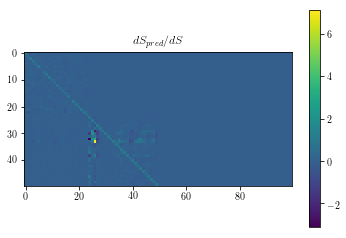

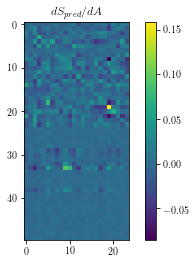

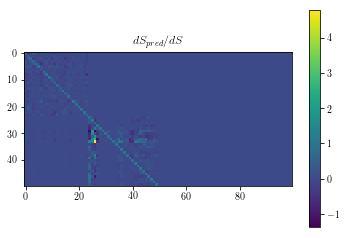

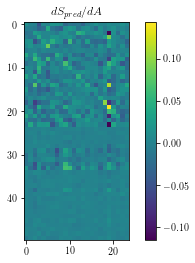

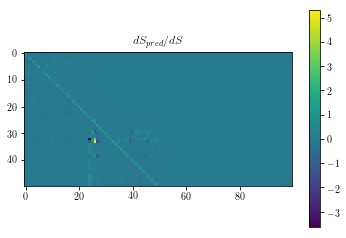

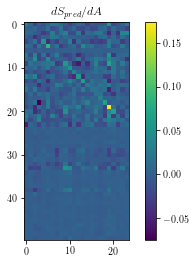

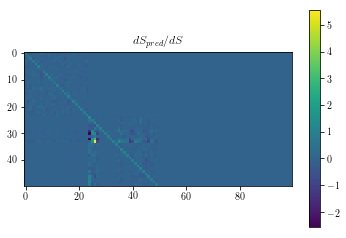

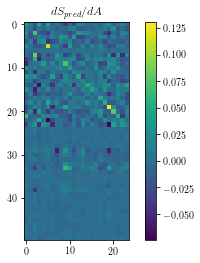

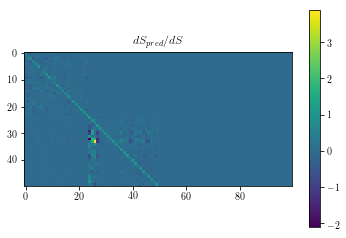

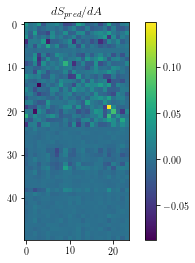

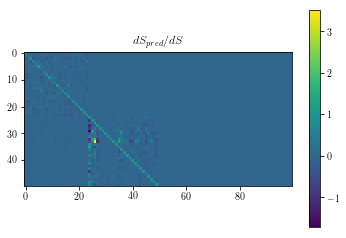

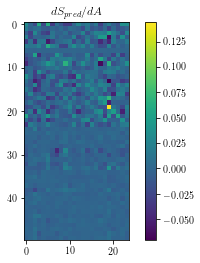

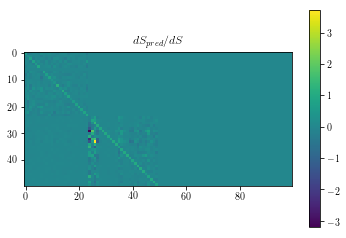

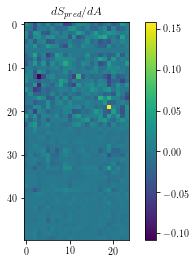

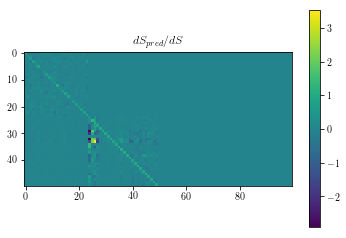

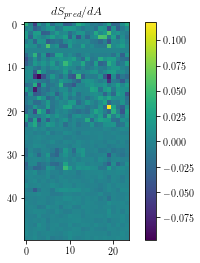

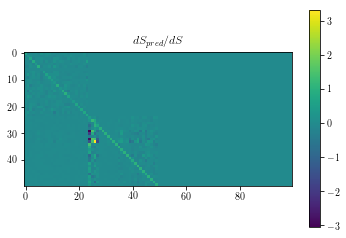

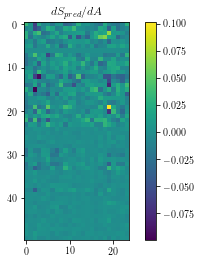

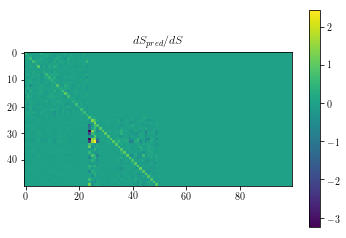

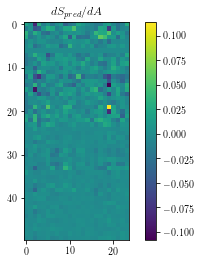

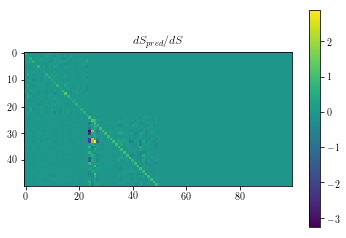

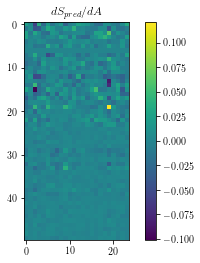

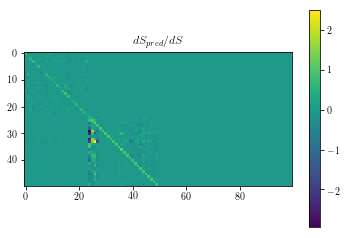

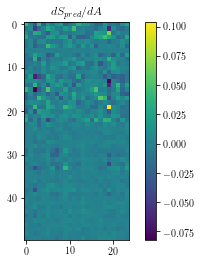

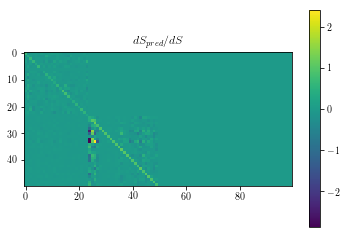

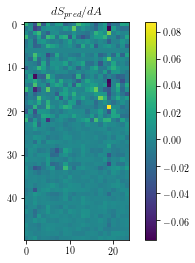

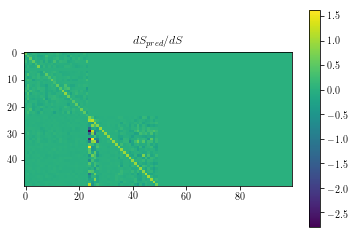

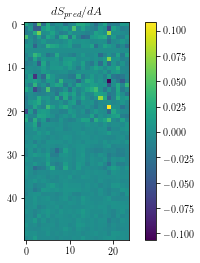

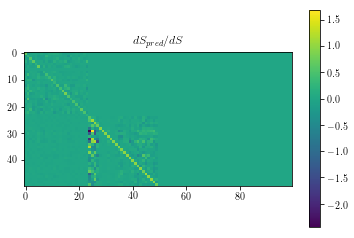

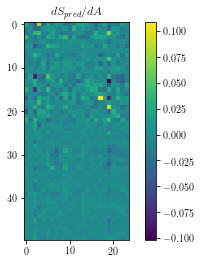

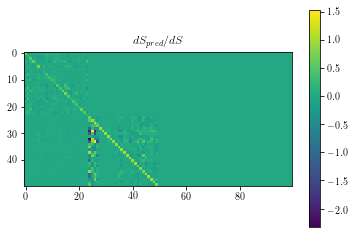

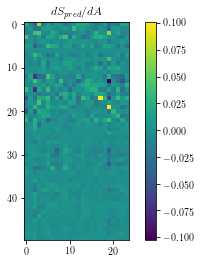

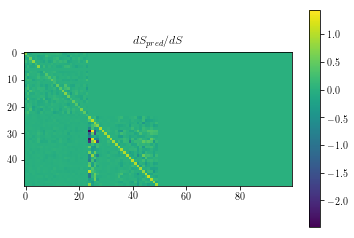

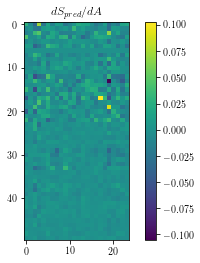

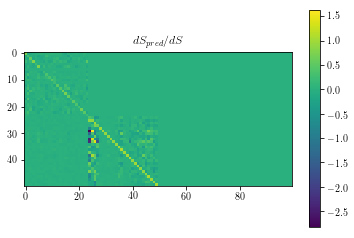

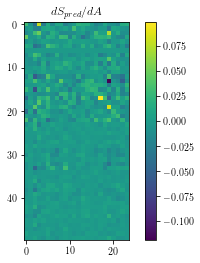

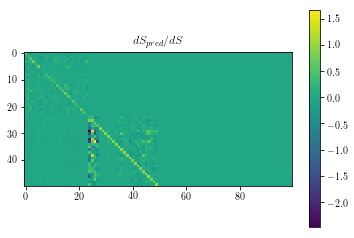

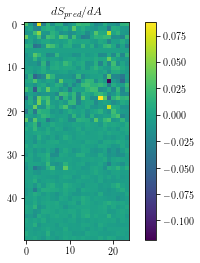

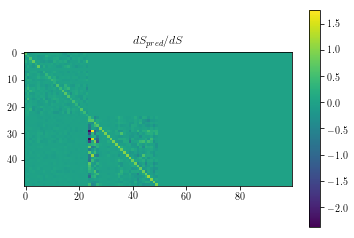

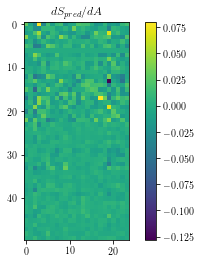

In [27]:
ep_states = []
ep_states_pred = []
ep_actions = []
misses = []

T = len(env.get_current_reference())
state0 = env.reset()
state = state0
env.render()
ep_states.append(state)
ep_states_pred.append(state[:-env.goal_dim])
state = env.normalize(state, env.state_bound)

# axes[0].cla()

score = 0.

agent.eval()
model_dynamics.eval()
step = 0
terminated = False

probs = []
entropies = []

while True:
    state_tensor = torch.tensor(torch.from_numpy(state).float().to(device).view(1, -1), requires_grad=True)
    action = agent(state_tensor).detach().cpu().numpy().squeeze()
    ep_actions.append(action)
    action_denorm = env.denormalize(action, env.action_bound)
    next_state, reward, done, _ = env.step(action_denorm)

    probs.append(reward[0].detach().cpu().numpy())
    entropies.append(reward[1].detach().cpu().numpy())

    action_tensor = torch.tensor(torch.from_numpy(action).float().to(device).view(1,-1), requires_grad=True)
    
    next_state_pred, next_state_pred_std, _ = model_dynamics(state_tensor, action_tensor)
    
    
    saliency_state = []    
    saliency_action = []

    for d in range(next_state_pred.shape[-1]):
#         state_tensor.grad.data.zero_()
#         next_state_pred[:, d].backward(retain_graph=True)
        grad = torch.autograd.grad(next_state_pred[:, d], state_tensor, retain_graph=True)
#         grad = state_tensor.grad.data.detach().numpy()
        saliency_state.append(grad[0].numpy())
    
        grad1 = torch.autograd.grad(next_state_pred[:, d], action_tensor, retain_graph=True)
        saliency_action.append(grad1[0].numpy())
    
    
#         state_tensor.grad.data.zero_()
    saliency_state = np.array(saliency_state).squeeze()
    plt.imshow(saliency_state)
    plt.colorbar()
    plt.title(r'$d S_{pred} /  dS $')
    plt.show()
    
    saliency_action = np.array(saliency_action).squeeze()
    plt.imshow(saliency_action)
    plt.colorbar()
    plt.title(r'$d S_{pred} /  dA $')
    plt.show()
    
  
    
    
    
    next_state_pred = env.denormalize(next_state_pred.detach().cpu().numpy().squeeze(), env.state_bound[:-env.goal_dim])

    ep_states.append(next_state)
    ep_states_pred.append(next_state_pred)
    next_state = env.normalize(next_state, env.state_bound)
    env.render()
    
    miss = torch.abs(torch.from_numpy(next_state).float().to(device)[:-env.goal_dim][torch.from_numpy(np.array(env.state_goal_mask, dtype=np.uint8)).byte()] -
                     torch.from_numpy(state).float().to(device)[-env.goal_dim:])

    misses.append(miss[:].max().detach().cpu().numpy())

    if len(misses) > 3 and np.all(np.array(misses[-3:]) > 0.1) and not terminated:
        terminated = True
        res_step = step
        miss_max_idx = np.argmax(miss[:].detach().cpu().numpy())
    elif not terminated:
        score = step
   
    if np.any(done):

        break
    state = next_state
    step += 1